<a href="https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergiuIliev/machine-learning-projects/blob/master/Solar_Forecasting_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bayesian Machine Learning | Final | 6 May 2020
# Sergiu Petre Iliev

In [32]:
## Import packages for analysis and plotting
import pandas as pd
import numpy as np
import math as m

import warnings                  # Ignore warnings on older package versions
warnings.simplefilter('ignore')

import itertools
import scipy.io as sio
from scipy import stats          # statisics Python package
import statsmodels.api as sm     # statsmodels is a complement to scipy for descriptive statistics models
                                 # Documentation https://www.statsmodels.org/stable/
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error   # Import scikit-learn module for accuracy calculation    

# Plotting libraries
import matplotlib.pyplot as plt  
import seaborn as sns; sns.set()

# Set default plotting style
sns.set_style("whitegrid", {'grid.color': '.9', 'figsize' : '(16,8)'})      # setting a default figure size and clean white aspect 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}, )  # useful for plot visualisation when running in Jupyter Notebooks
%matplotlib inline            

# 1. Forecasting Solar Power Generation (ARIMA Model)
In this part we will analyze a solar power generation dataset and build an ARIMA model to forecast solar power generation in time. In the 2nd part we will incorporate weather data to build a Bayesian Linear Regression Model to imrpove the forecast.

## a) Loading and visualising the dataset

### Import all of the experimental data

In [6]:
data_directory = './' 
solar_prod = pd.read_csv(data_directory + 'solar_prod.csv', sep=' ', index_col='Date')
solar_prod.head(4)

,Time,Energy
Date,,
2020-02-07,00:00:00,9145
2020-02-08,00:00:00,10430
2020-02-09,00:00:00,9704
2020-02-10,00:00:00,10699


### Visualising the evolution of the data in time

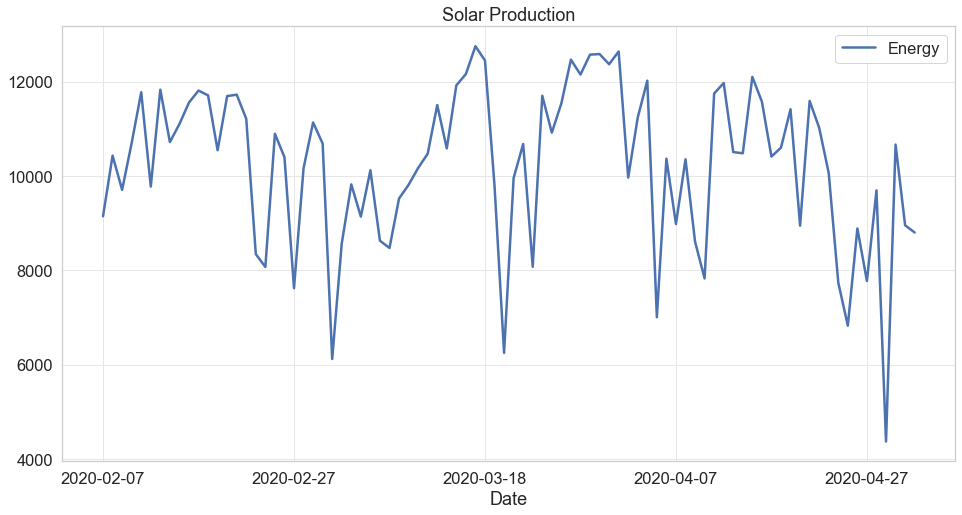

In [7]:
solar_prod.plot(title='Solar Production', figsize=(16,8));

### Visualising the day-to-day variation

***NB*** Looking at the dataset the time difference between data entries is exactly one day and constant for the entire dataset. 

This makes it simple to compute the derivative:
$\frac{difference\ in\ value\ between\ two\ consecutive\ days}{difference\ in\ time\ between\ the\ two\ days} = \frac{difference\ in\ value\ between\ two\ consecutive\ days}{1}$

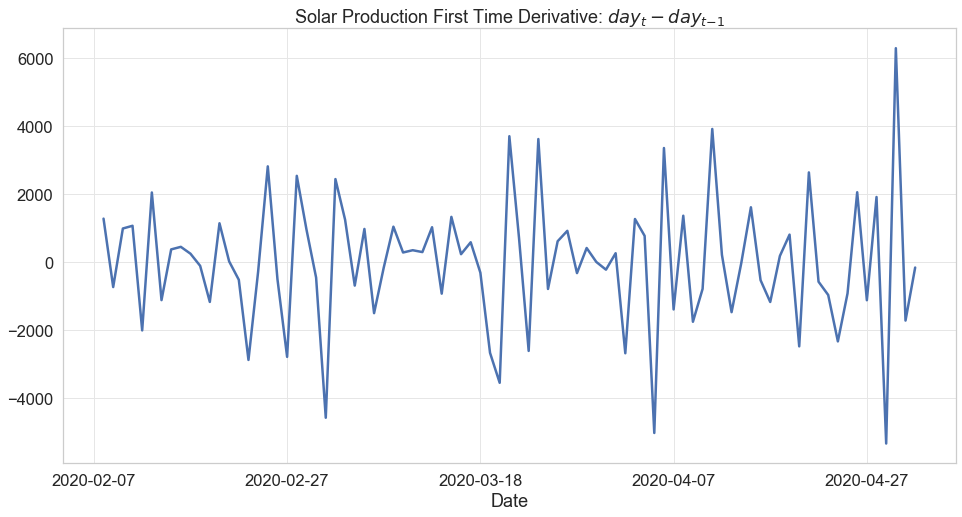

In [8]:
solar_prod.Energy.diff().plot(title=r'Solar Production First Time Derivative: $day_{t}-day_{t−1}$', figsize=(16,8));

### Visualising the dataset Auto-Correlation

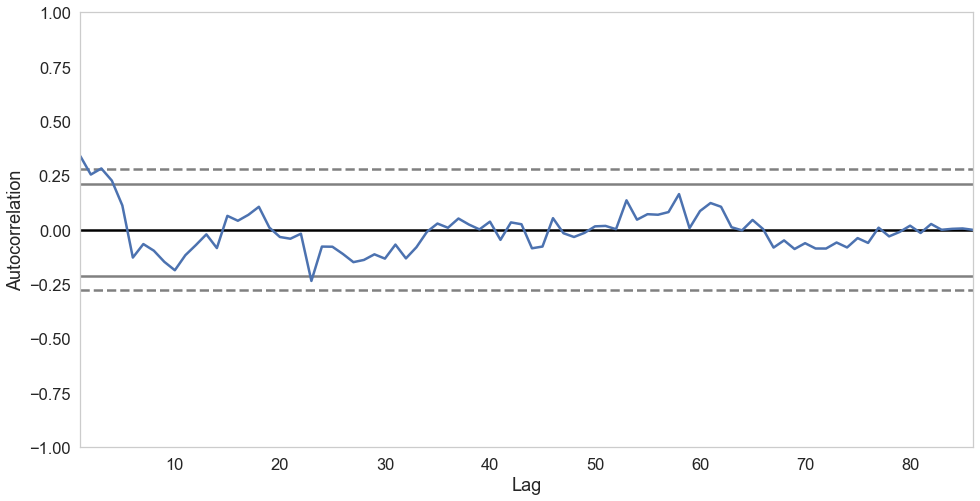

In [9]:
# Visualising the autocorrelation of the Energy
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(solar_prod.Energy)

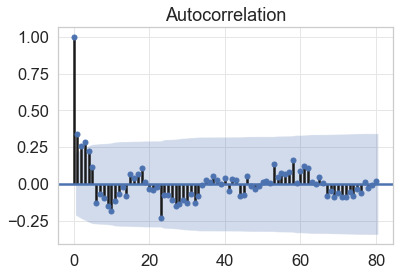

In [10]:
# Seeing this for a different lags levels
sm.graphics.tsa.plot_acf(solar_prod.Energy.values.squeeze(), lags=80);

In [20]:
weather_data.iloc[:,1:4]

,PM10,NO2,maxT
date,,,
2020-02-01,74,14,87
2020-02-02,57,11,85
2020-02-03,58,16,88
2020-02-04,56,14,87
2020-02-05,57,9,87
...,...,...,...
2020-04-28,45,0,93
2020-04-29,21,0,78
2020-04-30,41,1,91


## b) Interpretation
Weather systems are inherently non-steady state or non-equilibrium. Solar energy production is corellated with the weather data as it is directly affecting the physical process generating solar power. This correllation leads to the solar power to also fluctuate from day to day with the weather. Therefore, solar power is **not a strictly stationary process** since it evolves in time. 

The auto-correlation shows the process is not striclty stationary, but it is **weakly stationary** since the auto-covariance depends on lag. A higher auto-correlation level corresponds to an increase in the amount of information from timestep i that can be used to forecast timestep i+1. A perfectly random variable evolving in time would have an autocorrelation of 0 and its mean and variance would be constant in time. In our case, solar power has an autocorrelation within 0.25 thoughout the process and it is thus a weakly stationary process, with a mean and variance that can evolve in time. As can be seen in the last two auto-correlation figures (particularly clear in the last one), the process has a peak-to-peak or through-to-through time lag of 20. 

In other words, if the time series was shifted by 20 backwards or forwards, it would map onto itself in some way. Considering the correlation of a time series with a shifted version of itself is captured by the concept of autocorrelation. This evolution can be captured by an **autoregressive model** [ref](https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial). 
- the MA (moving average) model would not be a good selection due to the fact it models only stationary processes - lineary combinations of the generative noise term, whilst in this case the solar production is weakly stationary. Thus we can use it to model the noise of the dataset.
- the AR (auto-regressive) model uses the dependent relationship between an observation and some number of lagged observations. It assumes the process is weakly stationary with a mean of 0 and thus it cannot capture the trend, but the seasonality of the data.
- using I (integratio) we are fundamentally substracting an observation from an observation at the previous time step to make the time series stationary. The AR and MA models cannot be applied to non stationary modelse without obtaining  spurious regression coefficient. 
- from the autocorrelation plots we note that solar power is has a positive auto-corellaation for the first 5 lags - which would indicate this as a good starting point for the AR parameter.

The ARIMA model (AutoRegressive Integrated Moving Average) is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration above whilst combining the MA to model noise and AR to model seasonality [ref](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).

## c) ARIMA Model Construction
ARIMA model can be created using the statsmodels library as follows [ref](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html):
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

*A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model* [ref](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).

In [33]:
model = ARIMA(df.Energy, order=(0,1,0))   # AR(0), I(1), MA(0) and i.e. differencing) model - a random walk with drift
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Energy   No. Observations:                   85
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -764.000
Method:                           css   S.D. of innovations           1937.783
Date:                Thu, 07 May 2020   AIC                           1532.001
Time:                        14:05:58   BIC                           1536.886
Sample:                    02-08-2020   HQIC                          1533.966
                         - 05-02-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0471    210.182     -0.019      0.985    -415.996     407.902


In [34]:
model = ARIMA(df.Energy, order=(1,0,0))   # AR(1), I(0), MA(0) and i.e. autoregression with a lag of 1
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Energy   No. Observations:                   86
Model:                     ARMA(1, 0)   Log Likelihood                -755.662
Method:                       css-mle   S.D. of innovations           1583.062
Date:                Thu, 07 May 2020   AIC                           1517.324
Time:                        14:06:00   BIC                           1524.687
Sample:                    02-07-2020   HQIC                          1520.287
                         - 05-02-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.023e+04    257.146     39.780      0.000    9725.383    1.07e+04
ar.L1.Energy     0.3399      0.101      3.355      0.001       0.141       0.538
                                    Roots   

In [35]:
model = ARIMA(df.Energy, order=(0,0,1))   # AR(0), I(0), MA(1) and i.e. moving average
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Energy   No. Observations:                   86
Model:                     ARMA(0, 1)   Log Likelihood                -756.938
Method:                       css-mle   S.D. of innovations           1607.143
Date:                Thu, 07 May 2020   AIC                           1519.875
Time:                        14:06:03   BIC                           1527.238
Sample:                    02-07-2020   HQIC                          1522.839
                         - 05-02-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.024e+04    220.016     46.532      0.000    9806.563    1.07e+04
ma.L1.Energy     0.2727      0.094      2.896      0.005       0.088       0.457
                                    Roots   

**Log-likelyhood comparison**:
- AR(1), I(0), MA(0), log-lkelyhood = -755.662
- AR(0), I(1), MA(0), log-lkelyhood = -764.000
- AR(0), I(0), MA(1), log-lkelyhood = -756.938
The likelihood function measures the goodness of fit of a statistical model to a sample of data for given values of the unknown parameters. This suggest the most efficient simple model is AR(1)

When increasing model complexity, the log-lokelyhood difference should be bigger than the dimensionality increase to justify the added complexity and prevent overfitting. However, using the AIC and BIC criteria would be more effective for model selection.

## d) ARIMA Hyperparameter Sweep using Information Criteria
Varying the number of terms in the auto-regressive and moving average components of the ARIMA model. Then using the AIC and BIC criteria for model selection

In [36]:
model = ARIMA(df.Energy, order=(0,1,0))   # AR(0), I(1), MA(0) - the simplest model
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Energy   No. Observations:                   85
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -764.000
Method:                           css   S.D. of innovations           1937.783
Date:                Thu, 07 May 2020   AIC                           1532.001
Time:                        14:06:06   BIC                           1536.886
Sample:                    02-08-2020   HQIC                          1533.966
                         - 05-02-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0471    210.182     -0.019      0.985    -415.996     407.902


In [37]:
model = ARIMA(df.Energy, order=(3,1,3))   # AR(3), I(1), MA(3) - note this model does not converge
model_fit = model.fit(disp=0)
print(model_fit.summary())

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [38]:
model = ARIMA(df.Energy, order=(3,1,2))   # AR(3), I(0), MA(2) - the most complex MA model that converges
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Energy   No. Observations:                   85
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -747.300
Method:                       css-mle   S.D. of innovations           1585.476
Date:                Thu, 07 May 2020   AIC                           1508.601
Time:                        14:06:14   BIC                           1525.699
Sample:                    02-08-2020   HQIC                          1515.478
                         - 05-02-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -9.8397     85.148     -0.116      0.908    -176.727     157.048
ar.L1.D.Energy    -0.3219      0.353     -0.911      0.365      -1.015       0.371
ar.L2.D.Energy    -0.6226      0.216

## c) Hyperparameter sweep and model tuning

In [39]:
# Generate all possible hyperparameter combinations
p = range(0, 3) # AR parameter
d = [1]         # I parameter
q = range(0, 2) # MA parameter
pdq = list(itertools.product(p, d, q))
pdq

[(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 0), (2, 1, 1)]

In [40]:
for param in pdq:
    mod = sm.tsa.statespace.SARIMAX(df.Energy, order=param)
    results = mod.fit()

    print('ARIMA{} --- BIC: {:.0f} --- AIC: {:.0f}'.format(param, results.bic, results.aic))

ARIMA(0, 1, 0) --- BIC: 1532 --- AIC: 1530
ARIMA(0, 1, 1) --- BIC: 1516 --- AIC: 1511
ARIMA(1, 1, 0) --- BIC: 1524 --- AIC: 1519
ARIMA(1, 1, 1) --- BIC: 1520 --- AIC: 1513
ARIMA(2, 1, 0) --- BIC: 1520 --- AIC: 1513
ARIMA(2, 1, 1) --- BIC: 1523 --- AIC: 1513


We note that the model with the best AIC and BIC results is: **ARIMA(0, 1, 1) with BIC: 1516 and AIC: 1511**

## e) Forecasting solar power using the selected ARIMA model
We will forecast the last 10 days of the dataset and report the mean squared error with respect to the actual data.

In [41]:
model = ARIMA(df.Energy, order=(0,1,1))   # AR(0), I(1), MA(1) - selected model
model_fit = model.fit(disp=0)

In [42]:
holdout = 10                                                 # Select the ARIMA model on the entire dataset except the last 10 days       
train, test = (df.Energy[0:-holdout], df.Energy[-holdout:])  # Split the dataset into Test and Train sets

model=ARIMA(train,order=(0,1,1))                             # Define the selected model AR(0), I(1), MA(1)
model_fit = model.fit(disp=0)                                # Train the model

In [43]:
rolling_time = [x for x in train]
predictions = list()
RMS = list()
for t in range(len(test)):
    model = ARIMA(rolling_time, order=(0,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    rolling_time.append(obs)
    print('Predicted | Expected === %7.01f | %7.1f     RSE = %5.1f' % (yhat, obs, m.sqrt((yhat-obs)**2)))
    RMS.append(m.sqrt((yhat-obs)**2))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Predicted | Expected === 10877.4 | 10061.0     RSE = 816.4
Predicted | Expected === 10599.7 |  7738.0     RSE = 2861.7
Predicted | Expected ===  9564.8 |  6825.0     RSE = 2739.8
Predicted | Expected ===  8341.9 |  8886.0     RSE = 544.1
Predicted | Expected ===  8571.9 |  7773.0     RSE = 798.9
Predicted | Expected ===  8218.3 |  9694.0     RSE = 1475.7
Predicted | Expected ===  8794.2 |  4369.0     RSE = 4425.2
Predicted | Expected ===  7050.2 | 10664.0     RSE = 3613.8
Predicted | Expected ===  8397.2 |  8953.0     RSE = 555.8
Predicted | Expected ===  8560.5 |  8801.0     RSE = 240.5
Test MSE: 5248235.044


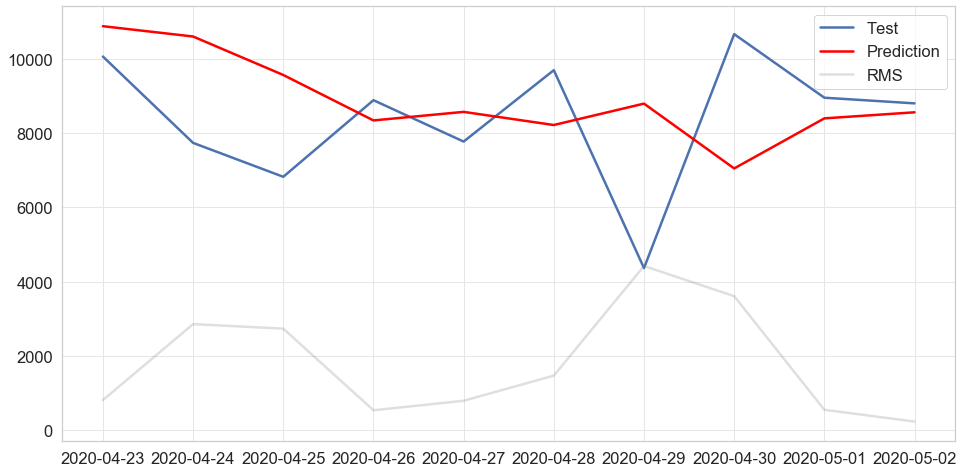

In [339]:
# Visualise the results
plt.figure(figsize=(16,8))
plt.plot(test, label='Test')
plt.plot(predictions, color='red', label='Prediction')
plt.plot(RMS, color='grey', alpha = 0.25, label='RMS')
plt.legend()

# 2. Forecasting Solar Power Generation (Bayes LM Model)

## a) Loading and visualising the dataset
We will analyze the solar power dataset taking into account weather  
### Import all of the experimental data to assess the need of transforming the variables inpreparation for modelling

In [14]:
weather_data = pd.read_csv(data_directory + 'weather_data.csv', sep=',', index_col='date')
weather_data.rename(columns={'maxt':'maxT', 'mint':'minT', 'no2':'NO2', 'pm25':'PM25', 'pm10':'PM10'}, inplace = True)
weather_data.head(4)

,PM25,PM10,NO2,maxT,minT
date,,,,,
2020-02-01,126,74,14,87,66
2020-02-02,130,57,11,85,63
2020-02-03,90,58,16,88,63
2020-02-04,85,56,14,87,61


### Visualising the evolution of the weather variables in time (variables' variation)

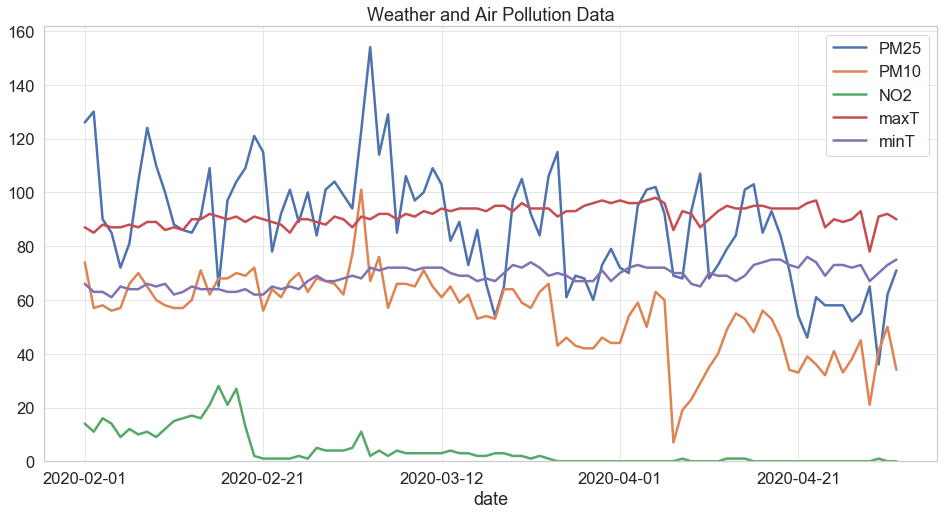

In [15]:
weather_data.plot(title='Weather and Air Pollution Data', ylim=(0), figsize=(16,8));

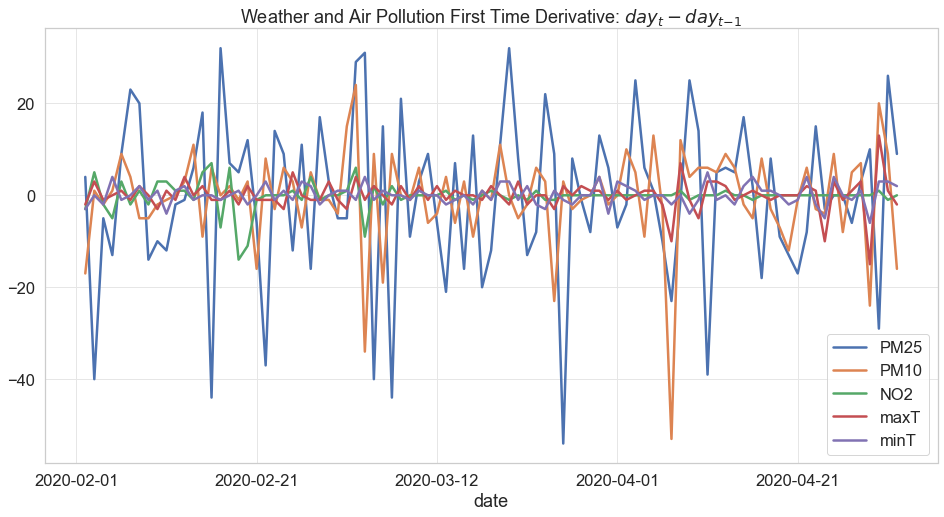

In [16]:
# Plotting the first derivative allows us to observe the stationary  behaviour of the variables 
weather_data.diff().plot(title=r'Weather and Air Pollution First Time Derivative: $day_{t}-day_{t−1}$', figsize=(16,8));

For the dataset to be suitable to a Bayesian Linear regression model, the predictor variables should be in the same PDF functiona family. This is the case for the variables we observe here i.e. there are no variables that follow an exponential function to which we would need to apply a log-trainsform to bring them to the same evolution as the other variables. According to the two plots above all variables follow linear periodically varying functions. Therefore, **there is no need to transform any of the variables** in preparation for Bayesian Linear Regression. 

## b) Box plot construct and interpretation

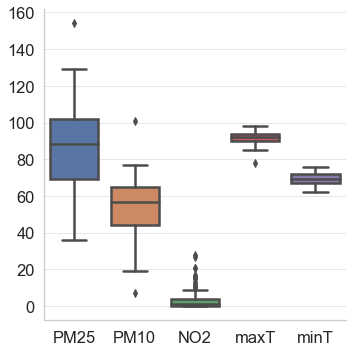

In [44]:
sns.factorplot(data=df.iloc[:,1:], kind="box");

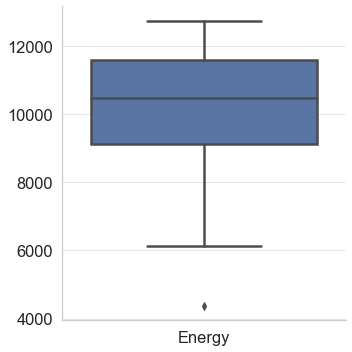

In [45]:
sns.factorplot(data=df.iloc[:,0:1], kind="box");

WAnalyzing the box plots above the following observations come to mind:
- all predictor variable box plots have a similar magnitude and error bounds, NO2 is almost an outlier
- there are two sets of predictors: particulates PM25 & PM10 and temperatures minT & maxT
- the NO2 gas is in a lower range than the other two sets
- Energy has a similar percentual range and variation, but it requires a **scale factor of 0.01** for reaching a magnitude similar to the the other variables

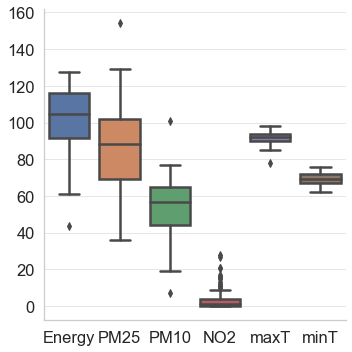

In [46]:
df_scaled=df.iloc[:,0:1]*.01
df_scaled=df_scaled.join(df.iloc[:,1:])
sns.factorplot(data=df_scaled, kind="box");

## c) Merging the datasets and evaluating their predictive power looking at their correlation with solar power
### Visualising the dataset Correlation

In [47]:
df = pd.DataFrame.join(solar_prod, weather_data) # Join the two datasets into a global one
df.drop(columns='Time', inplace = True)          # Drop the time dataset since it is constant in time (midnight)
df.dropna()                                      # Drop the entries where we don't have data for both weather and solar production
df.sample(4)

,Energy,PM25,PM10,NO2,maxT,minT
Date,,,,,,
2020-03-02,6119,94,77,5,87,69
2020-04-12,11969,73,40,0,93,69
2020-04-03,11240,95,59,0,96,73
2020-03-13,11502,82,65,4,93,70


In [48]:
df.corr()   # Pearson correlation matrix of the dataset

,Energy,PM25,PM10,NO2,maxT,minT
Energy,1.000000,-0.041157,0.033898,0.139681,0.480427,-0.205580
PM25,-0.041157,1.000000,0.588004,0.247816,-0.140581,-0.240481
PM10,0.033898,0.588004,1.000000,0.458440,-0.003491,-0.266891
NO2,0.139681,0.247816,0.458440,1.000000,-0.299577,-0.579452
maxT,0.480427,-0.140581,-0.003491,-0.299577,1.000000,0.483415
minT,-0.205580,-0.240481,-0.266891,-0.579452,0.483415,1.000000


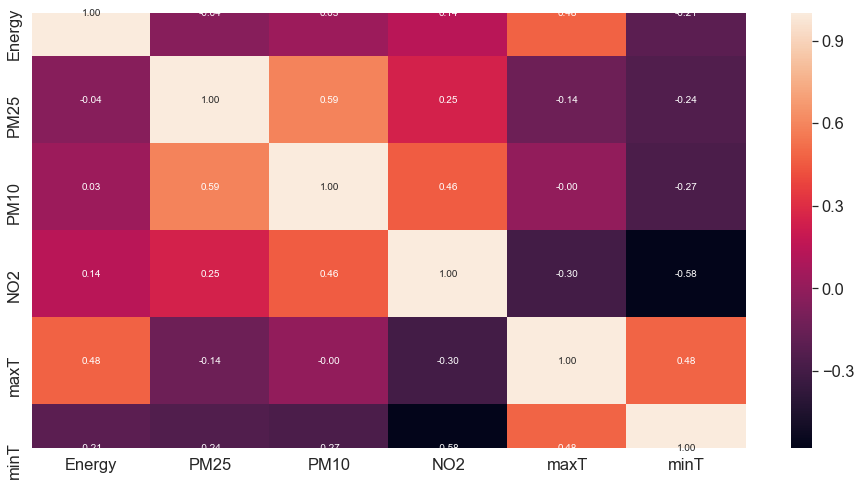

In [49]:
# Visualising the correlation matrix using a heatmap
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

<Figure size 1152x576 with 0 Axes>

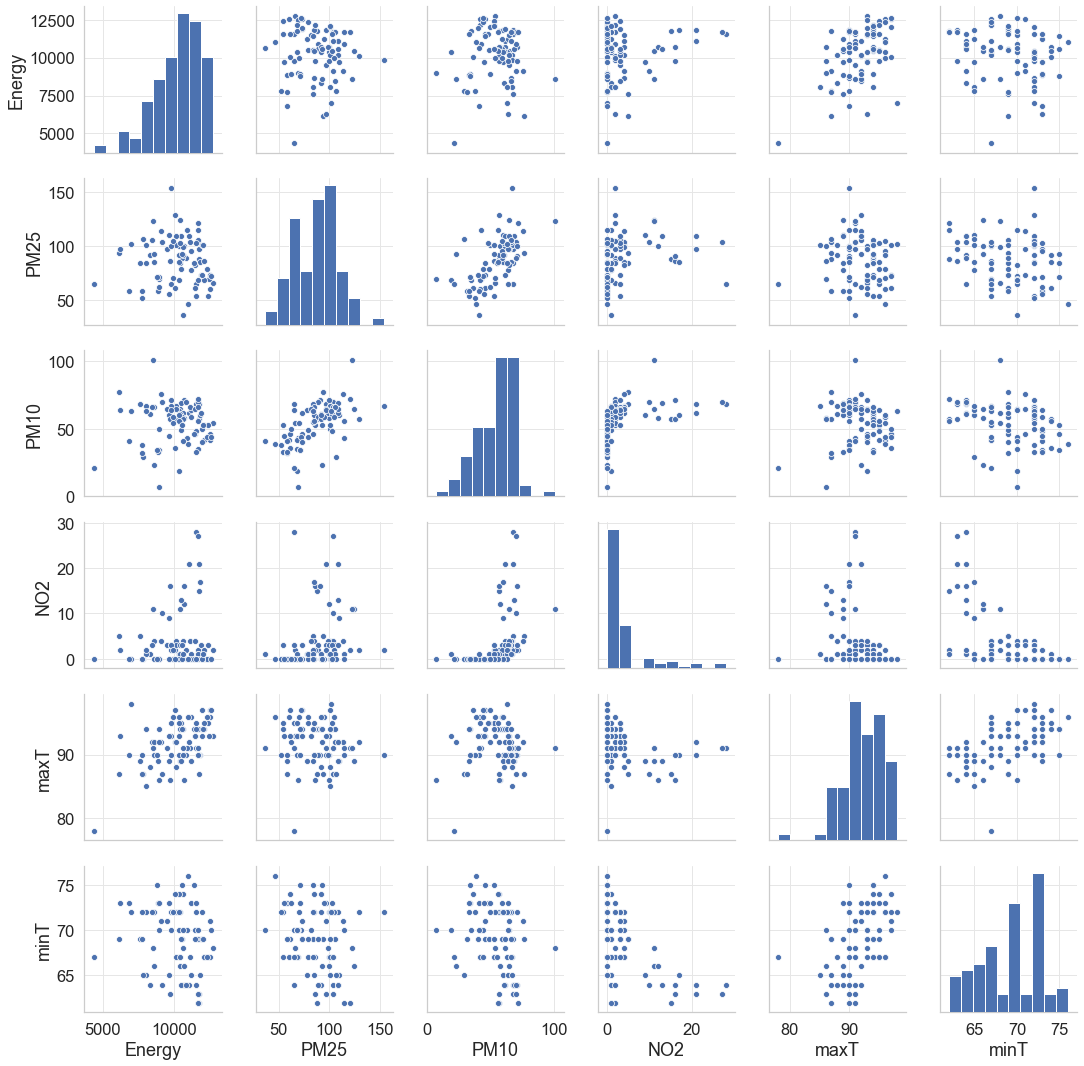

In [173]:
# Visualising the correlation matrix using a PairPlot
plt.figure(figsize=(16,8))
sns.pairplot(df, size=2.5)

<Figure size 1152x576 with 0 Axes>

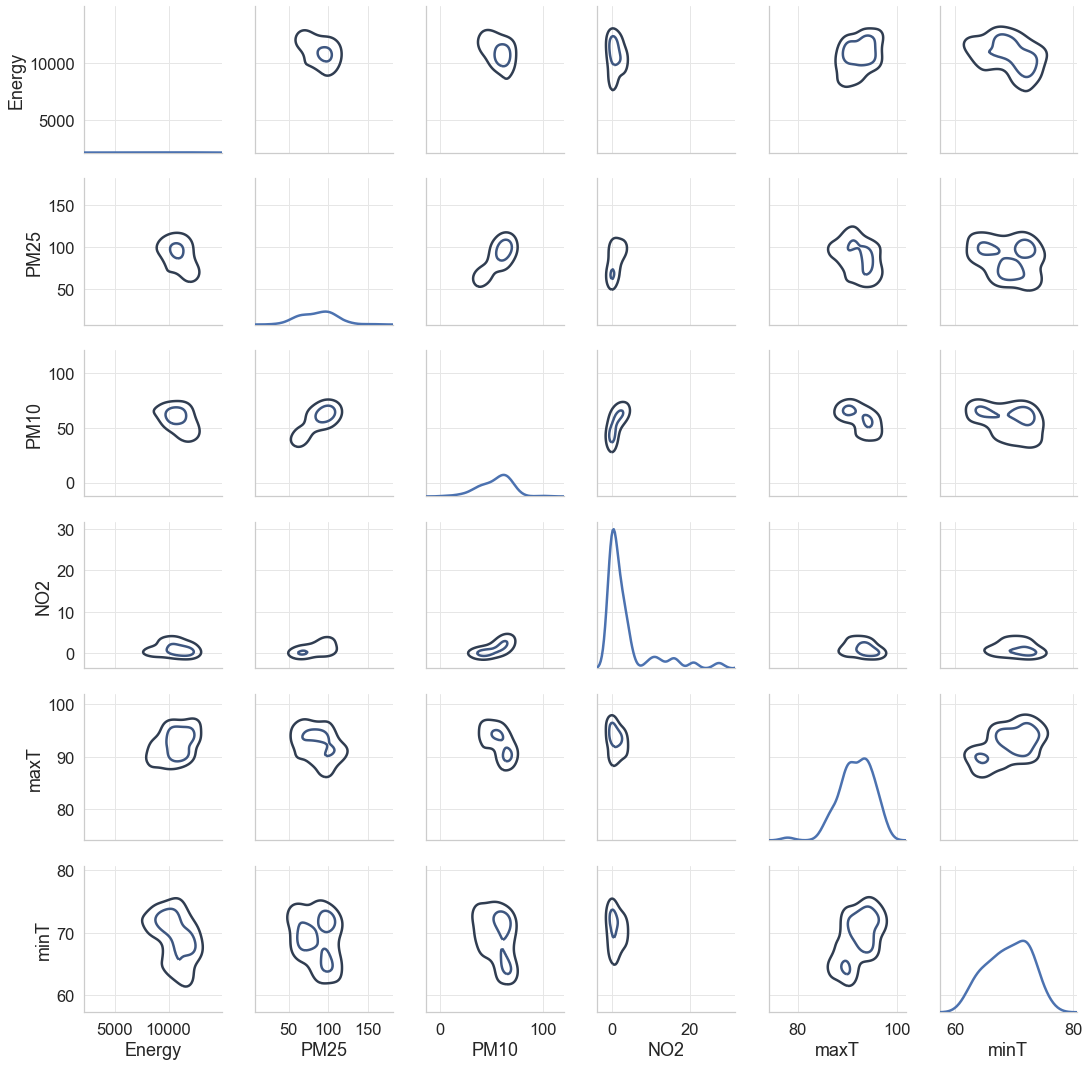

In [172]:
# Visualising the correlation matrix using a PairGrid
plt.figure(figsize=(16,8))
g = sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=2);

### Interpreting the correlation plots
Pandas DataFrame has a corr method that calculates Pearson’s correlation coefficient between all couples of numeric columns of the DataFrame. These can then be visualised using the Seaborn package as in the three figures above. Some of the observations that can be made are the following:
- Energy is most strongly correlated with maxT and minT (heatmap) -- the physical interpretation is that more solar power is generated on warm days (because warm days are also generally sunny) 
- From the PairPlots we can infer the highest energy is achieved when the particulates have their lowest leve -- which phyically means there is less pollution to block the solar radiation from reaching the pannels 
- Therefore, we could expect that the temperature variables would have the strongest predictive power, followed by the air pollution particulates 

### Definning the response and predictor variables

In [70]:
Y = df.Energy            # Define the energye generated as the response variable
X = df.iloc[:, 1:]       # Define all the weather variables as the predictors

## d) Constructing a  Bayesian Linear Regression Model with a LASSO prior
### LASSO Prior Definition
Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression [ref](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b).

LASSO (Least Absolute Srinkage) is an optimisation technique for the Bayes Linear regression. It allows the application of an exponential prior to force predictor variables to turn on or off [ref](https://www.meche.engineering.cmu.edu/education/courses/24-786.html). 

The Lasso estimate for linear regression parameters can be interpreted as a Bayesian posterior mode estimate when the regression parameters have independent Laplace (i.e., double-exponential) priors. Gibbs sampling from this posterior is possible using an expanded hierarchy with conjugate normal priors for the regression parameters and independent exponential priors on their variances. [ref](https://github.com/ColCarroll/pydata_nyc2017/blob/master/Bayesian%20Regression.ipynb)

The Bayesian Lasso provides interval estimates (Bayesian credible intervals) that can guide variable selection. Moreover, the structure of the hierarchical model provides both Bayesian and likelihood methods for selecting the Lasso parameter. Slight modifications lead to Bayesian versions of other Lasso-related estimation methods, including bridge regression and a robust variant.
[ref](https://www.tandfonline.com/doi/abs/10.1198/016214508000000337)


$$
-\log p(\mathbf{w} | X, \mathbf{y}) \propto \frac{1}{\sigma^2} \sum_j (\mathbf{x}_j \cdot \mathbf{w} - y_j)^2 + \frac{1}{2\sigma^2_w} \sum_j w_j^2
$$

$$
\lambda = \frac{1}{2\sigma^2_w} 
$$

Conditioned on $σ^2$, the prior distribution of each regression coefficient is double exponential with a mean of 0 and scale σ/λ, where λ is the lasso shrinkage parameter. As λ increases, the coefficients tend towards 0. This allows lasso regression to turn off coefficients actig towards feature selection whereas Ridge Regression can only shrink coefficients close to zero.

In [66]:
# !conda install -c conda-forge pymc3  # Install the BayesLM module if not already available 
import pymc3 as pm # Package Documentation https://docs.pymc.io/
import theano.tensor as tt

In [67]:
# Python implementation of Bayesian Lasso -- building upon the work done by ColCarroll: https://github.com/ColCarroll/pydata_nyc2017/blob/master/Bayesian%20Regression.ipynb
def lasso_regression(X, y):
    with pm.Model() as model:
        β = pm.HalfCauchy('β', beta=10.)
        w = pm.Laplace('w', mu=0., b=β, shape=X.shape[1])
        σ = pm.HalfCauchy('σ', beta=10.)
        y_obs = pm.Normal('y', mu=tt.dot(X, w), sd=σ, observed=y.squeeze())
    return model

class PyMCModel(object):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

In [68]:
ridge = PyMCModel(lasso_regression)
ridge.fit(X, Y);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w, β]


Sampling 4 chains, 0 divergences:   0%|                                                   | 0/10000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|                                           | 9/10000 [00:00<01:52, 89.19draws/s]

Sampling 4 chains, 0 divergences:   0%|                                          | 18/10000 [00:00<01:52, 88.64draws/s]

Sampling 4 chains, 0 divergences:   0%|                                          | 26/10000 [00:00<02:02, 81.40draws/s]

Sampling 4 chains, 0 divergences:   0%|▏                                         | 32/10000 [00:00<02:53, 57.47draws/s]

Sampling 4 chains, 0 divergences:   0%|▏                                         | 37/10000 [00:00<03:25, 48.59draws/s]

Sampling 4 chains, 0 divergences:   0%|▏                                         | 42/10000 [00:00<03:31, 47.07draws/s]

Sampling 4 chain

RuntimeError: Chain 2 failed.

In the interest of implementation efficiency, I will use the Bayesian Linear Regression in package from MATLAB [ref](https://www.mathworks.com/help/econ/bayeslm.html).

To this purpose, exporting the structured data for training and testing the model:

In [79]:
# sio.savemat('X.mat', {name: col.values for name, col in X.items()})
# sio.savemat('y.mat', Y)
# sio.savemat('DF.mat', {name: col.values for name, col in df.items()})
df.to_csv('DF.csv');

*-- Project continued in a separate file in Matlab --*